In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub

In [61]:
data = pd.read_csv("wine-reviews.csv")
data = data.iloc[:,1:]
data = data.dropna(subset=['description','price'])
data.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,NaN,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem


(array([  395.,   680.,  1772.,  2886.,  6099.,  8902., 11745., 15767.,
        16014., 11324., 14361., 10564.,  8871.,  5935.,  3449.,  1406.,
          482.,   207.,    69.,    47.]),
 array([ 80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,
         91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99., 100.]),
 <BarContainer object of 20 artists>)

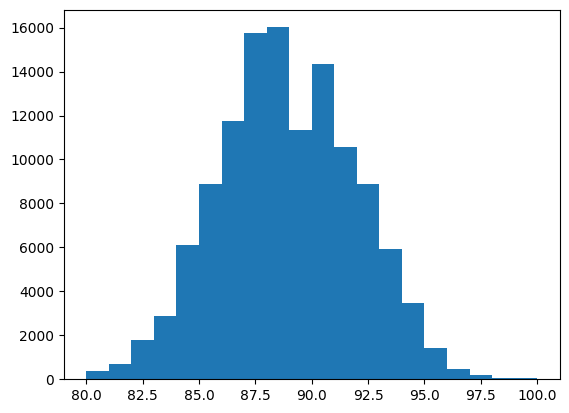

In [62]:
plt.hist(data.points, bins = 20)

In [63]:
data['label'] = (data.points >= 90).astype(int)
data = data[['description','label']]
data.tail()

,description,label
129966,Notes of honeysuckle and cantaloupe sweeten th...,1
129967,Citation is given as much as a decade of bottl...,1
129968,Well-drained gravel soil gives this wine its c...,1
129969,"A dry style of Pinot Gris, this is crisp with ...",1
129970,"Big, rich and off-dry, this is powered by inte...",1


In [64]:
train, val, test = np.split(data.sample(frac=1),[int(0.8*len(data)),int(0.9*len(data))]) #splits up the data for train val and test, 80%, 10% and 10% respectively

In [65]:
len(train),len(val),len(test)

(96780, 12097, 12098)

In [66]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df["description"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [67]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

In [68]:
list(train_data)[0]

(<tf.Tensor: shape=(1024,), dtype=string, numpy=
 array([b'Frothy cream sets the stage and acts as a nice backdrop to fragrant aromas of peach, citrus, white flower and mineral. This is a clean and fresh bubbly to drink on hot summer afternoons. It has an easy, no-fuss mouthfeel but ends with a much-needed blast of citrus zest.',
        b'This wine captures the passion fruit notes typical of Marlborough Sauvignon Blanc, then underscores them with a silky textural element. Hints of white nectarine and celery stalk add nuance to the long, white-grapefruit-inflected finish.',
        b'Everything is front-end in this Chardonnay. The nose has plenty of tropical fruit, and with some toasted oak in the background. Decent acidity supports the fruit and the smooth mouthfeel is pleasing, but the wine cuts off abruptly with a somewhat short, resinous close.',
        ...,
        b'Made with organically cultivated grapes, this vibrant white offers a refined fragrance of yellow flower, orchard f

Embedding + Model

In [69]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [70]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.53327733, -0.2162157 , -0.0931065 , ..., -0.10352376,
         0.04597267,  0.08656409],
       [ 0.29889226, -0.09083612, -0.06982586, ...,  0.01786539,
        -0.39174154, -0.12005527],
       [ 0.24439299, -0.47847292, -0.19932352, ...,  0.14913423,
        -0.01750941,  0.05544849],
       ...,
       [ 0.36808825,  0.0113855 ,  0.2869266 , ..., -0.12132958,
         0.01458882, -0.01096948],
       [ 0.22887707, -0.7032598 , -0.23019825, ...,  0.07973789,
         0.01765714, -0.03006377],
       [ 0.26099697, -0.1684508 , -0.01677542, ...,  0.05503245,
        -0.0534276 , -0.01583226]], dtype=float32)>

In [71]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16,activation='relu'))
model.add(tf.keras.layers.Dropout(0.4)) #this drops out nodes that are not working and removes the node
model.add(tf.keras.layers.Dense(16,activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))


In [72]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(), #https://www.analyticsvidhya.com/blog/2021/03/binary-cross-entropy-log-loss-for-binary-classification/
              metrics=['accuracy'])

In [73]:
model.evaluate(train_data)

95/95 [==============================] - 1s 8ms/step - loss: 0.7007 - accuracy: 0.4424


[0.7007438540458679, 0.44243645668029785]

In [74]:
model.evaluate(valid_data)

12/12 [==============================] - 0s 7ms/step - loss: 0.7006 - accuracy: 0.4465


[0.7005906105041504, 0.4464743435382843]

In [75]:
history = model.fit(train_data,epochs=5,validation_data=valid_data)

Epoch 1/5


95/95 [==============================] - 88s 917ms/step - loss: 0.6241 - accuracy: 0.6349 - val_loss: 0.5100 - val_accuracy: 0.7760
Epoch 2/5
95/95 [==============================] - 83s 869ms/step - loss: 0.4850 - accuracy: 0.7561 - val_loss: 0.4224 - val_accuracy: 0.8119
Epoch 3/5
95/95 [==============================] - 86s 904ms/step - loss: 0.4159 - accuracy: 0.8261 - val_loss: 0.4012 - val_accuracy: 0.8216
Epoch 4/5
95/95 [==============================] - 83s 867ms/step - loss: 0.3812 - accuracy: 0.8456 - val_loss: 0.3922 - val_accuracy: 0.8174
Epoch 5/5
95/95 [==============================] - 82s 864ms/step - loss: 0.3555 - accuracy: 0.8576 - val_loss: 0.3917 - val_accuracy: 0.8267


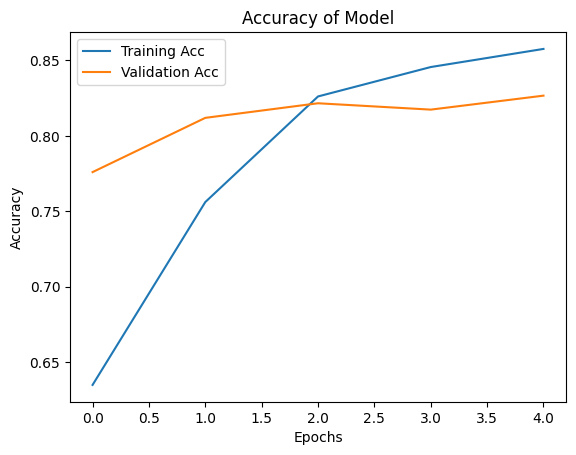

In [76]:
plt.plot(history.history['accuracy'], label="Training Acc")
plt.plot(history.history['val_accuracy'], label="Validation Acc")
plt.title("Accuracy of Model")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [77]:
model.evaluate(test_data)

12/12 [==============================] - 1s 82ms/step - loss: 0.3889 - accuracy: 0.8243


[0.3888972997665405, 0.8242684602737427]

LTSM

In [78]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label:text))

In [79]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'to', 'it', 'its', 'on', 'fruit', 'aromas',
       'palate', 'finish'], dtype='<U17')

In [80]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True #masking is to handle varaible sequence lengths
    ),
    tf.keras.layers.LSTM(32),  # LSTM layer with hidden size of 32
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')

])

In [81]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(), #https://www.analyticsvidhya.com/blog/2021/03/binary-cross-entropy-log-loss-for-binary-classification/
              metrics=['accuracy'])

In [82]:
model.evaluate(train_data)
model.evaluate(valid_data)

12/12 [==============================] - 1s 80ms/step - loss: 0.6938 - accuracy: 0.4132


[0.693832516670227, 0.4131602942943573]

In [83]:
history = model.fit(train_data, epochs=5,validation_data=valid_data)

Epoch 1/5
95/95 [==============================] - 22s 195ms/step - loss: 0.5416 - accuracy: 0.7182 - val_loss: 0.3833 - val_accuracy: 0.8235
Epoch 2/5
95/95 [==============================] - 19s 197ms/step - loss: 0.3756 - accuracy: 0.8342 - val_loss: 0.3630 - val_accuracy: 0.8362
Epoch 3/5
95/95 [==============================] - 19s 198ms/step - loss: 0.3525 - accuracy: 0.8460 - val_loss: 0.3500 - val_accuracy: 0.8385
Epoch 4/5
95/95 [==============================] - 19s 198ms/step - loss: 0.3413 - accuracy: 0.8495 - val_loss: 0.3520 - val_accuracy: 0.8418
Epoch 5/5
95/95 [==============================] - 19s 199ms/step - loss: 0.3357 - accuracy: 0.8524 - val_loss: 0.3463 - val_accuracy: 0.8414


In [84]:
model.evaluate(test_data)

12/12 [==============================] - 1s 76ms/step - loss: 0.3512 - accuracy: 0.8440


[0.3512004315853119, 0.8440238237380981]

In [86]:
from tensorflow.keras.models import save_model

# Save the model
model.save('wine_review_classifier',save_format='tf')


INFO:tensorflow:Assets written to: wine_review_classifier\assets


INFO:tensorflow:Assets written to: wine_review_classifier\assets


In [87]:
from tensorflow.keras.models import load_model
model = load_model('wine_review_classifier')  # Again, no .h5 extension


In [97]:
# New text to classify
text_to_predict = ["A sleek mix of tart berry, stem and herb, along with a hint of oak and chocolate, this is a fair value in a widely available, drink-now Oregon Pinot. The wine oak-aged for six months, whether in neutral or re-staved is not indicated."] 

# Use the model to predict the class
predictions = model.predict(text_to_predict)

# Output the prediction
print(predictions)

1/1 [==============================] - 0s 35ms/step
[[0.02826696]]
